In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import plotly.express as px
import numpy as np            
np.set_printoptions(suppress=True)
from scipy import stats
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # this MUST come before any tf call.
import copy
import re
import random
import datetime
import tqdm
import time
import warnings
warnings.filterwarnings('ignore')
import multiprocessing
print('Number of CPU:',multiprocessing.cpu_count())

from sklearn.utils import shuffle

pd.set_option('display.max_rows',None)	#Show all rows
pd.set_option('display.max_columns',None)	#Show all cols
pd.set_option('display.max_colwidth', None)	#不要truncate cell

global truncate_size
truncate_size=18000

global window_length
window_length=150

Number of CPU: 128


# Load data & EDA & Cleaning

In [2]:
feature_cols=[
 'tinit_cabin',
 't_env',
 'i_solar_left',
 'i_solar_right',
 'occupt_frt_left',
 'occupt_frt_right',
 'occupt_rr_left',
 'occupt_rr_right',
 'occupt_rr_mid',
 'vel_velocity',
 'vfrair_frtleft',
 'vfrair_rrleft',
 'vfrair_frtright',
 'vfrair_rrright',
 'frntairdistbnmode',
 'ta_ductout_defrost',
 'ta_ductout_frtlevent',
 'ta_ductout_frtrivent',
 'ta_ductout_rearvent',
 'ta_ductout_frtlefoot',
 'ta_ductout_frtrifoot',
 'ta_ductout_rearfoot',
 'ccu_onofflampreq',
 'ccu_rcponoffreq']

label_cols=[
 'tcabin_frtleft',
 'tcabin_frtright',
 'tcabin_rrleft',
 'tcabin_rrright']

num_cols=[
 'tinit_cabin',
 't_env',
 'i_solar_left',
 'i_solar_right',
 'vel_velocity',
 'vfrair_frtleft',
 'vfrair_rrleft',
 'vfrair_frtright',
 'vfrair_rrright',
 'ta_ductout_defrost',
 'ta_ductout_frtlevent',
 'ta_ductout_frtrivent',
 'ta_ductout_rearvent',
 'ta_ductout_frtlefoot',
 'ta_ductout_frtrifoot',
 'ta_ductout_rearfoot',
 'tcabin_frtleft',
 'tcabin_frtright',
 'tcabin_rrleft',
 'tcabin_rrright'
]
cate_cols=[
 'occupt_frt_left',
 'occupt_frt_right',
 'occupt_rr_left',
 'occupt_rr_right',
 'occupt_rr_mid',
 'frntairdistbnmode',
 'ccu_onofflampreq',
 'ccu_rcponoffreq'
]

value_range={'tinit_cabin': [-40, 60],
 't_env': [-40, 60],
 'i_solar_left': [0, 1200],
 'i_solar_right': [0, 1200],
 'occupt_frt_left': (0, 1),
 'occupt_frt_right': (0, 1),
 'occupt_rr_left': (0, 1),
 'occupt_rr_right': (0, 1),
 'occupt_rr_mid': (0, 1),
 'ccu_onofflampreq': (0, 1),
 'ccu_rcponoffreq': (0, 1),
 'vel_velocity': [0, 160],
 'vfrair_frtleft': [0, 250],
 'vfrair_rrleft': [0, 250],
 'vfrair_frtright': [0, 200],
 'vfrair_rrright': [0, 200],
 'frntairdistbnmode': (0, 1, 2, 3, 4, 5, 6, 7),
 'ta_ductout_defrost': [-40, 75],
 'ta_ductout_frtlevent': [-40, 75],
 'ta_ductout_frtrivent': [-40, 75],
 'ta_ductout_rearvent': [-40, 75],
 'ta_ductout_frtlefoot': [-40, 75],
 'ta_ductout_frtrifoot': [-40, 75],
 'ta_ductout_rearfoot': [-40, 75],
 'tcabin_frtleft': [-40,60],
 'tcabin_frtright': [-40,60],
 'tcabin_rrleft': [-40,60],
 'tcabin_rrright': [-40,60]}

def Myinterpolate(df):
    #Interpolate VB_2&TT_1
    df['timestamps']=np.arange(0,df.shape[0]*50,50)
    df_interpolated=pd.DataFrame({'timestamps':np.arange(0,df.shape[0]*50,1)})
    df_interpolated=pd.merge(df,df_interpolated,how='right',on='timestamps')
    df_interpolated[num_cols]=df_interpolated[num_cols].interpolate(method='linear')
    df_interpolated[label_cols]=df_interpolated[label_cols].interpolate(method='linear')
    df_interpolated[cate_cols]=df_interpolated[cate_cols].interpolate(method='nearest')
    df_interpolated['cos_path']=df['cos_path'].iloc[0]
    return df_interpolated

def Myfillna(df):
    df[num_cols]=df[num_cols].interpolate(method='linear')
    df[cate_cols]=df[cate_cols].interpolate(method='nearest')
    return df

def Preprocessing(df):
    #Sort every test by time
    df=df.sort_values(by=['timestamps']).reset_index(drop=True)
    #Fill invalid value as None
    for col,values in value_range.items():
        if col in num_cols:
            min_,max_=values
            data.loc[~(min_<=data[col])&(data[col]<=max_),col]=np.nan             #set num values outside of the value range as none
        else:
            data.loc[~data[col].isin(values),col]=np.nan                        #set cate values outside of the value range as none      
    #Fill vfrair na with 0
    vfrair_cols=['vfrair_frtleft','vfrair_rrleft','vfrair_frtright','vfrair_rrright']
    df.loc[~(df['ccu_onofflampreq'].isna() & df['ccu_rcponoffreq'].isna()),vfrair_cols]=df.loc[~(df['ccu_onofflampreq'].isna() & df['ccu_rcponoffreq'].isna()),vfrair_cols].fillna(0)
    #Truncate1
    if 'VB_2' in file or 'TT_1' in file: df=df.iloc[12:,:]                        #truncate first 5s data
    else: df=df.iloc[600:,:]                                                      #truncate first 0.1s data
    df.reset_index(drop=True,inplace=True)
    #Interpolate VB_2 & TT_1
    if 'VB_2' in file or 'TT_1' in file:df=Myinterpolate(df)                      #interpolate 5s data to 0.1s
    #Initial Temp
    df['tinit_cabin_backup']=df['tinit_cabin'].copy()                    #backup the tinit CAN message
    df['tinit_cabin']=df['tinit_cabin'].iloc[0]                          #Keep the 1st CAN message as initial input
    #Fill Occup Signals
    for signal in [ 'occupt_frt_left','occupt_frt_right','occupt_rr_left','occupt_rr_right','occupt_rr_mid']:
        df[signal]=stats.mode(df[signal])[0][0]
    #Drop na rows
    df=df.dropna(how='any',subset=feature_cols+label_cols).reset_index(drop=True)
    return df

In [3]:
root=r'../Data/V2/ET7'
data=[]
for file in tqdm.tqdm(os.listdir(root),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
    if 'checkpoint' in file:continue
    #if not (('Winter' in file) or ('Summer' in file)):continue        #先只用summer test
    file_path=os.path.join(root,file)
    datum=pd.read_csv(file_path)
    data.append(datum)
data=pd.concat(data,ignore_index=True)

#Some PreProcessing
data_interpolated=[]
for file in tqdm.tqdm(data['cos_path'].unique(),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
    data_seg=data[data['cos_path']==file]
    #Preprocessing
    data_seg=Preprocessing(data_seg)
    #Truncate2
    data_seg=data_seg.iloc[0:truncate_size,:]                                                         #truncate size to first 24000 steps,namely 1800s(30 min)    
    data_interpolated.append(data_seg)

data=pd.concat(data_interpolated,ignore_index=True)
del data_interpolated

#Check num of invalid values, you can see that not many of them are invalid
print('Num of invalid values:')
data.isna().sum()

100%|██████████| 84/84 [01:11<00:00,  1.17it/s]                                                                                                                                                                


Num of invalid values:


cos_path                      0
type                    1118327
model_type              1118327
timestamps                    0
ccu_onofflampreq              0
ccu_rcponoffreq               0
tinit_cabin                   0
t_env                         0
i_solar_left                  0
i_solar_right                 0
occupt_frt_left               0
occupt_frt_right              0
occupt_rr_left                0
occupt_rr_right               0
occupt_rr_mid                 0
vel_velocity                  0
vfrair_frtleft                0
vfrair_rrleft                 0
vfrair_frtright               0
vfrair_rrright                0
frntairdistbnmode             0
ta_ductout_defrost            0
ta_ductout_frtlevent          0
ta_ductout_frtrivent          0
ta_ductout_rearvent           0
ta_ductout_frtlefoot          0
ta_ductout_frtrifoot          0
ta_ductout_rearfoot           0
tcabin_frtleft                0
tcabin_frtright               0
tcabin_rrleft                 0
tcabin_r

In [ ]:
#检查缺失情况
for file in data['cos_path'].unique():
    if 'Winter' in file:
        print(file)
        data_seg=data[data['cos_path']==file]
        plt.figure(figsize=(10,4))
        sns.heatmap(data_seg.isna())
        plt.show()

In [ ]:
#Check Outliers
for col in num_cols:
    plt.figure(figsize=(12,3))
    plt.hist(data[col])
    plt.title(col)
    plt.show()

In [5]:
tmp=[]
for file in data['cos_path'].unique():
    tmp.append(data.loc[data['cos_path']==file,'tinit_cabin'].iloc[0])

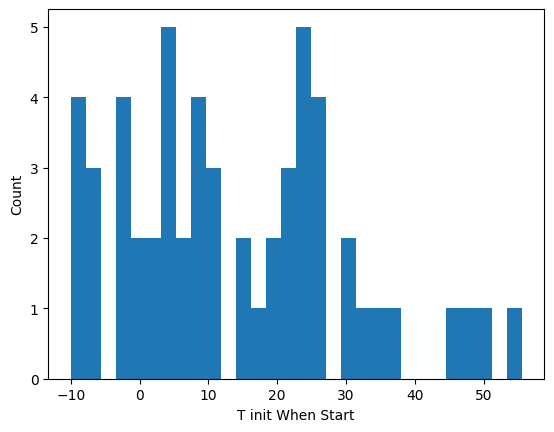

In [12]:
plt.hist(tmp,bins=30)
plt.xlabel('T init When Start')
plt.ylabel('Count')
plt.show()

In [ ]:
#label cols viz
for col in label_cols:
    plt.figure(figsize=(12,3))
    for file in data['cos_path'].unique():
        data_seg=data[data['cos_path']==file]
        plt.plot(list(range(len(data_seg))),data_seg[col])
    plt.title(col)
    plt.show()

In [ ]:
#numerical cols viz
for col in num_cols:
    plt.figure(figsize=(12,3))
    for file in data['cos_path'].unique():
        data_seg=data[data['cos_path']==file].iloc[:,:]
        #print(file)
        plt.plot(list(range(len(data_seg))),data_seg[col])
    plt.title(col)
    #plt.legend()
    plt.show()

In [ ]:
for col in cate_cols:
    plt.figure(figsize=(12,3))
    for file in data['cos_path'].unique():
        data_seg=data[data['cos_path']==file].iloc[:,:]
        #print(file)
        plt.plot(list(range(len(data_seg))),data_seg[col])
    plt.title(col)
    #plt.legend()
    plt.show()

# Data Split

In [4]:
data_count=data['cos_path'].value_counts()
data_count.sort_values(ascending=False)

simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_1.auto23 city.xlsx                                                                             18000
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_02_-14AmT_ColdStartAuto23_ManualMode&Rec-20220110171033.xlsx                                         18000
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_04_city L1toL2_-1.5_blower40_AUTODEFOG ACoff_aqs_5_7.xlsx                                      18000
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_1_charging auto23.xlsx                                                                         18000
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_1.auto23 Tamb11 highway.xlsx                                                                   18000
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Mod

In [5]:
train_file=[
#Summer
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/Auto_23-高速-_27-07-2021 17_01_00.dat',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/Cold_Start_Auto_23_Dual_Evap_Force_VB43_TT05_V1_CZ_05-08-2021 14_42_43.dat',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/Hot_Start_Auto_23_Rear_OnOff_VB43_TT05_V1_CZ_05-08-2021 17_54_31.dat',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/V7-AUTO-23-双抢-26-07-2021 17_42_00.dat',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/Auto_23_高速-返程_27-07-2021 19_26_08.dat',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/V7-怠速-AUTO-23-26-07-2021 12_11_59.dat',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/V7_Auto 23-Solar-City_Idle_31-07-2021 17_22_45.dat',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/V7-城市+高速-Auto-23-25-07-2021 17_14_48.dat',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/Cold_Start_Auto_23_Test_Force_VB43_TT05_V1_CZ_04-08-2021 15_11_20.dat',
#Winter VB_1
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Winter Test/Test_1_ColdStart_Auto_23_FrOnRrOff_NoSun2Sun-AMB=-8_VB-43-050-05RC-V2-LH_20-11-2021 12_44_22.dat',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Winter Test/Test_1_Auto_23_FrontOnRearOn_Chiller_Only-AMB=-6_VB-43-050-05RC-V2-LH_19-11-2021 12_44_24.dat',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Winter Test/Test_2_Auto_23_FrontOnRearOn_Dual Mode_Hot_Start-AMB=-6_VB-43-050-05RC-V2-LH_19-11-2021 15_42_07.dat',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Winter Test/Test_3_frnton-rearon-Fast_Charge & Auto_23_HP_Only-AMB=-9_VB-43-050-05RC-V2-LH_21-11-2021 14_24_23.dat',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Winter Test/Test_2_frnton-rearon-_FC-Auto_23_-AMB=-15-nosolar-_VB-43-050-05RC-V3-LH_24-11-2021 15_50_38.dat',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Winter Test/Test_5_Auto23_4P_30%_OSA-AMB=-6_VB-43-050-05RC-V2-LH_19-11-2021 16_57_09.dat',
#Winter TT_1
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_02_Tamb-10AUTO23FrnonRearOnDuctCalibration_TT33_V050.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_Model_02_ForceTT33_Winter_Auto23RearOffOn@Amb-16-20211217141259.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_ForceTT33_Winter-20211227100717_IdleAuto23SteadyCaliration@-Amb12_NoSolar.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_03_-20Amb_Hotstart_Auto23OldParameter-20220113185953.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_ForceTT33_Winter-20211228111510_IdleWithSunloadAuto23@Amb-6.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_04_Auto23_BlowerReduce-20220118173535.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_04_ForceTT33_Winter-20211226163548_IdleNoSunloadAuto23@Amb-15.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_Tamb11AUTO23FrnonRearOn_TT33_V050.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_Model_01_ForceTT33_Winter_Auto23RearOnOff@Amb-17-20211217093743.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_-21Amb_Auto23PTC2Heatpump-20220111095403.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_ForceTT33_Winter_CityAuto23SyncColdStart-20211221100119.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_02_ForceTT33_Winter-20211228153452_CityAuto23RearOffOn@Amb-5.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_-19Amb_Auto23_Idle-20220112095310.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_Tamb-10AUTO23FrnonRearOnColdStart_TT33_V050.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_ForceTT33_Winter-20211229104943_HighwayAuto23FrontOnly@Amb-13.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_ForceTT23_Winter_IdleAuto23FrontOnlyCalibration-20211218104009.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_04_-18Amb_Maxdef_Auto23_ECO-20220111154445.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_04_-10Amb_Auto23_ColdStart_NoPassenger-20220114142438.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test4_01_-17Amb_Auto23RearOff2On-20220117155134.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_02_-14AmT_ColdStartAuto23_ManualMode&Rec-20220110171033.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_ForceTT33_Winter_IdelAuto23ColdStart-20211222102305.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_02_Tamb-1AUTO23FrnonRearOn_TT33_V050.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_02_-18Amb_Auto23PTCOnlyAfteCalibration-20220112121019.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test3_01_-17Amb_MaxDfrost_Auto23RearOff-20220117155134.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_04_ForceTT33_Winter-Auto23DrivingOutFromUndergroundParking_20211218165202.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_02_ForceTT33_Winter_Auto23FrontOnlyCalibration-20211218135320.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_03_ForceTT33_Winter-20211230171513_IdleHotStartAuto23@Amb-17.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_03_ForceTT33_Winter-20211228171210_ChargeAuto23@Amb10.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_02_ForceTT33_Winter_Auto23FrontOnly_HotStart-20211219164300.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_ForceTT33_Winter_Auto23ColdStart-20211223104836.xlsx',
#Autumn
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_1.auto23 city.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_1.山路 auto23.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_4.modify solar auto23 city.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_03_VB23_AutumnTest-_FrontOnlyAuto23&Autodefog_20211119164251.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_3-Amb=9-AUTO23.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_02_VB23_AutumnTest_ChargeWithCabinOffOn-20211117133405.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_3.city auto23 rear on_off.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_01_mountain_AUTODEFOG ACON_aqs_5_7.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_1.auto23 normal_ECO.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_03_AUTODEFOG ACON_aqs_5_7_AMB11.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_5_max defrost -auto23.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_1-Amb=15-前开后关AUTO23 从车库出来.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_2-Amb=16-快充双开测试_Auto21.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_1.auto23 Tamb11 highway.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_1_charging auto23.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_04_city L1toL2_-1.5_blower40_AUTODEFOG ACoff_aqs_5_7.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_2-Amb=15-AUTO23Highway.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_3.auto23.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_3.Amb=12-内外循环测试-AUTO23.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_01_VB23_AutumnTest_Auto23@Amb10-20211119113449.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_5.auto 23.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_1.idle auto23_L1toL2_-1.5.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_4-Amb=0-改标定冷起.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_04_city_AUTODEFOG ACON_aqs_5_7.xlsx'
]
validate_file=[
#Summer
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/V7-高速+城市-Auto-23-25-07-2021 19_05_10.dat',
#Winter VB_1
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Winter Test/Test_2_HotStart_Auto_23_FrOnRrOn_HPOnly-AMB=-8_VB-43-050-05RC-V2-LH_20-11-2021 15_04_50.dat',
#Winter TT_1
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_05_-13Amb_Auto23Rearoff-20220114172010.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_03_ForceTT33_Winter-20211227155039_DrivingAuto23@Amb-15_Low&HighSpeed.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_02_ForceTT33_Winter-20211227100717_IdleAuto23SteadyCaliration@-Amb12_NoSolar2Solar.xlsx',
#Autumn
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_3.山路 auto23.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_2.auto23 eco.xlsx',
]

test_file=[
#Summer
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/V7-AUTO-23-高速+城市-26-07-2021 18_54_12.dat',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/Auto-23-城市工矿_27-07-2021 21_12_32.dat',
#Winter TT_1
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_ForceTT33_Winter_Auto23Driving-20211219150552.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Winter Test/Test_8_frnton-rearon-_Auto_23_PTC-0nly-AMB=-12-AMBtest_VB-43-050-05RC-V2-LH_23-11-2021 14_16_07.dat',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_Model_03_ForceTT33_Winter_Tset23ManulBlowerLevel1@Amb-17_-20211217161353.xlsx',
#Autumn
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_2.auto23_L1toL2_-1.5.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_01_VB23_AutumnTest_SyncAuto23@Amb6-20211118102426.xlsx',
'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_03_VB23_AutumnTest_CityAuto23-20211117153252.xlsx'
]

train_file=[file for file in train_file if file in data_count[data_count==truncate_size].index]
validate_file=[file for file in validate_file if file in data_count[data_count==truncate_size].index]

In [6]:
train_data=data[data['cos_path'].isin(train_file)]
validate_data=data[data['cos_path'].isin(validate_file)]
test_data=data[data['cos_path'].isin(test_file)]

In [7]:
#Change the order of files in train & validate data randomly
train_data=pd.concat(shuffle([train_data[train_data['cos_path']==file] for file in train_data['cos_path'].unique()]),ignore_index=True)
validate_data=pd.concat(shuffle([validate_data[validate_data['cos_path']==file] for file in validate_data['cos_path'].unique()]),ignore_index=True)

In [8]:
print('训练数据量：',train_data.shape[0],'\n',data_count[data_count.index.isin(train_file)],'\n')
print('验证数据量：',validate_data.shape[0],'\n',data_count[data_count.index.isin(validate_file)],'\n')
print('测试数据量：',test_data.shape[0],'\n',data_count[data_count.index.isin(test_file)])

训练数据量： 1242000 
 simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_1.auto23 city.xlsx                                                                             18000
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_ForceTT33_Winter_CityAuto23SyncColdStart-20211221100119.xlsx                                      18000
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_04_-18Amb_Maxdef_Auto23_ECO-20220111154445.xlsx                                                      18000
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_ForceTT33_Winter-20211227100717_IdleAuto23SteadyCaliration@-Amb12_NoSolar.xlsx                    18000
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_04_-10Amb_Auto23_ColdStart_NoPassenger-20220114142438.xlsx                                           18000
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Win

In [9]:
n_files_train=len(train_file)
n_files_validate=len(validate_file)
n_files_test=len(test_file)

n_batches_train=truncate_size//(10)-1  #shortest data.shape[0]//window_step//n_files_train
n_batches_validate=truncate_size//(10)-1
n_batches_test=test_data.shape[0]//(10)//32-1

print('Train n batches:',n_batches_train)           #data.shape[0]//window_step//batch_size
print('Valid n batches:',n_batches_validate)           #data.shape[0]//window_step//batch_size
print('Test n batches:',n_batches_test)           #data.shape[0]//window_step//batch_size

print('\nTrain n files:',n_files_train)
print('Valid n files:',n_files_validate)
print('Test n files:',n_files_test)

Train n batches: 1799
Valid n batches: 1799
Test n batches: 393

Train n files: 69
Valid n files: 7
Test n files: 8


In [13]:
#Summer/Winter data size
data_count.groupby(data_count.index.str.contains('Winter')).sum().reset_index().rename(columns={'index':'Winter','cos_path':'count'})

,Winter,count
0,False,728124
1,True,766207


# Batch Generator

In [10]:
def batch_generator(data,batchsize=32,feature_cols=feature_cols,label_cols=label_cols,window_length=window_length,lag=1):
    """
        Input:
            data:pd.DataFrame
            batchsize:int
            feature_cols:List[string]
            label_cols:List[string]
            window_length:int
            lag:int               #y lag after X
        Yield:
            Tuple(pd.DataFrame,pd.DataFrame)
            
    """
    batch=[]
    idx=0
    data_L=[data[data['cos_path']==file].reset_index(drop=True) for file in data['cos_path'].unique()]           #generate batch isolately from each file
    for datum in data_L:
        start=0
        X=datum[feature_cols]
        y=datum[label_cols]
        while start+window_length<=datum.shape[0]-1-lag:
            end=start+window_length
            batch.append((X.iloc[start:end,:].values,y.iloc[end+lag,:].values))
            start=end
            idx+=1
            if idx==batchsize:
                idx=0
                X_batch,y_batch=zip(*batch)
                yield (np.array(X_batch),np.array(y_batch))
                batch=[]
    return

In [11]:
def batch_generator_shuffled(data,batchsize=32,feature_cols=feature_cols,label_cols=label_cols,window_length=window_length,window_step=10,lag=1):
    """
        Input:
            data:List[pd.DataFrame]
            batchsize:int
            feature_cols:List[string]
            label_cols:List[string]
            window_length:int
            window_step:int
            lag:int               #y lag after X
        Yield:
            Tuple(pd.DataFrame,pd.DataFrame)
            
    """
    
    batch=[]
    idx=0                               #current num of samples in the batch container
    data=data.reset_index(drop=True)
    
    #Find out file borders to prevent cross-file window
    file_borders=data.reset_index(names='index_cp').groupby('cos_path')['index_cp'].max().values
    
    #Split X & y, shuffle y separately, corresponding to X.index by y['raw_idx']
    X=data[feature_cols]
    y=data[label_cols]
    
    #downsampling by window_step
    y_sampled_idx=list(range(0,y.shape[0],window_step))
    
    #shuffle y to generate samples from random location of random file
    y_shuffled_sampled_idx=shuffle(y_sampled_idx,random_state=42)
    
    for i in range(len(y_shuffled_sampled_idx)):
        raw_idx=y_shuffled_sampled_idx[i]      #get raw_idx
        if any(raw_idx<file_border and raw_idx+window_length>=file_border for file_border in file_borders):continue      #drop cross_file window
        
        y_=y.iloc[raw_idx+window_length+lag-1].values          #由于lag为1不会产生X,y跨文件的的问题，如果要考虑lag>1，则需要额外加continue drop条件
        X_=X.iloc[raw_idx:raw_idx+window_length,:].values
        
        batch.append((X_,y_))
        
        #yield a batch and empty the container
        idx+=1
        if idx==batchsize:
            idx=0
            X_batch,y_batch=zip(*batch)
            yield (np.array(X_batch),np.squeeze(np.array(y_batch)))
            batch=[]

    return

In [12]:
def batch_generator_stateful(data=train_data,feature_cols=feature_cols,label_cols=label_cols,window_length=window_length,lag=1,ts_length=truncate_size,weights=False):
    """
        Input:
            data:pd.DataFrame
            feature_cols:List[string]
            label_cols:List[string]
            window_length:int
            window_step:int
            lag:int               #y lag after X
            ts_length:int         #ts length for each cos_path file
        Yield:
            Tuple(pd.DataFrame,pd.DataFrame)
            
    """
    batchsize=data['cos_path'].nunique()
    files=data['cos_path'].unique()
    data_L=[data[data['cos_path']==file].reset_index(drop=True) for file in files]           #generate batch isolately from each file
    
    start=0
    while start+window_length<=ts_length-1-lag:
        batch_X=[]
        batch_y=[]
        batch_w=[]
        end=start+window_length
        for i in range(len(files)):
            datum=data_L[i]
            file=files[i]
            batch_X.append(datum[feature_cols].iloc[start:end,:].values)
            batch_y.append(datum[label_cols].iloc[end+lag,:].values)
            if 'Summer' in file:batch_w.append(7)
            else:batch_w.append(2)

        if weights:yield (np.array(batch_X),np.array(batch_y),np.array(batch_w))
        else:yield (np.array(batch_X),np.array(batch_y))
        start=end
    return

In [14]:
feature_cols

['tinit_cabin',
 't_env',
 'i_solar_left',
 'i_solar_right',
 'occupt_frt_left',
 'occupt_frt_right',
 'occupt_rr_left',
 'occupt_rr_right',
 'occupt_rr_mid',
 'vel_velocity',
 'vfrair_frtleft',
 'vfrair_rrleft',
 'vfrair_frtright',
 'vfrair_rrright',
 'frntairdistbnmode',
 'ta_ductout_defrost',
 'ta_ductout_frtlevent',
 'ta_ductout_frtrivent',
 'ta_ductout_rearvent',
 'ta_ductout_frtlefoot',
 'ta_ductout_frtrifoot',
 'ta_ductout_rearfoot',
 'ccu_onofflampreq',
 'ccu_rcponoffreq']

In [39]:
tmp=batch_generator_stateful(train_data)
tmp_batch=next(tmp)
print(tmp_batch[0].shape,tmp_batch[1].shape,tmp_batch[2].shape)
i=0
for batch in tmp:
    #print(batch[0].shape,batch[1].shape)
    i+=1
print(i)

(46, 150, 24) (46, 4) (46,)
118


In [41]:
tmp=batch_generator_stateful(validate_data)
tmp_batch=next(tmp)
print(tmp_batch[0].shape,tmp_batch[1].shape,tmp_batch[2].shape)
i=0
for batch in tmp:
    #print(batch[0].shape,batch[1].shape)
    i+=1
print(i)

(4, 150, 24) (4, 4) (4,)
118


In [20]:
tmp=batch_generator(test_data)
tmp_batch=next(tmp)
print(tmp_batch[0].shape,tmp_batch[1].shape,tmp_batch[2].shape)
i=0
for batch in tmp:
    #print(batch[0].shape,batch[1].shape)
    i+=1
print(i)

(32, 150, 24) (32, 4)
15


# Benchmark

In [18]:
mae=[]
for file in data['cos_path'].unique():
    y=data.loc[data['cos_path']==file,label_cols].shift(1)
    y_pred=data.loc[data['cos_path']==file,'tinit_cabin_backup']
    file_mae=np.abs(np.stack([y_pred,y_pred,y_pred,y_pred]).T-y).to_numpy().flatten()
    file_mae=file_mae[~np.isnan(file_mae)]
    mae+=list(file_mae)
    
    print(file,'\tbenchmark MAE：',np.mean(mae))
    # plt.figure(figsize=(12,4))
    # plt.plot(list(range(y_pred.shape[0])),y_pred,'b',label='Pred')
    # for i in range(4):
    #     plt.plot(list(range(y_pred.shape[0])),y.iloc[:,i],label=f'Temp{i}')
    # plt.legend()
    # plt.show()
mae=np.array(mae)
mae=mae[~np.isnan(mae)]
print('Overall Benchmark MAE:\t',np.mean(mae))

simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_1.auto23 city.xlsx 	benchmark MAE： 2.2849870409467194
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_1.山路 auto23.xlsx 	benchmark MAE： 1.6313835490860606
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_04_city L1toL2_-1.5_blower40_AUTODEFOG ACoff_aqs_5_7.xlsx 	benchmark MAE： 2.3414635164916566
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_1_charging auto23.xlsx 	benchmark MAE： 2.0212442948219347
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_1.auto23 Tamb11 highway.xlsx 	benchmark MAE： 1.8021069670537253
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_2-Amb=16-快充双开测试_Auto21.xlsx 	benchmark MAE： 1.7847446941496752
simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_3.山路 auto23.xlsx 	benchmark MAE： 1.

# Modeling

In [13]:
from keras import models
from keras import layers
from keras import callbacks
from keras import optimizers
from keras import initializers
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model
from IPython.display import display

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(69, 150, 24)]      0           []                               
                                                                                                  
 reshape (Reshape)              (69, 150, 24, 1)     0           ['Input[0][0]']                  
                                                                                                  
 ConvFilter (Conv2D)            (69, 30, 24, 150)    900         ['reshape[0][0]']                
                                                                                                  
 LRU1 (LeakyReLU)               (69, 30, 24, 150)    0           ['ConvFilter[0][0]']             
                                                                                              

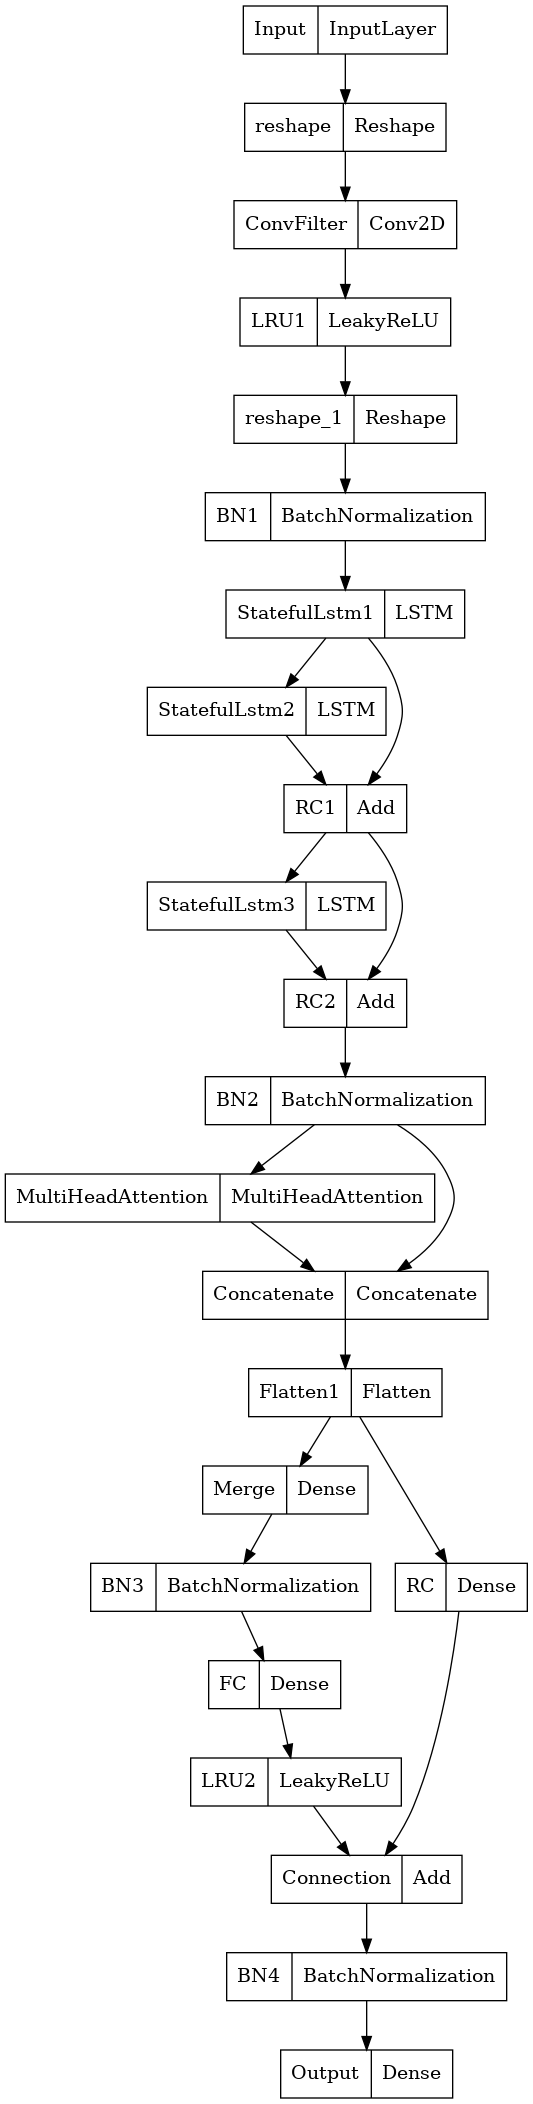

In [14]:
def KS_error(y_true,y_pred):
    loss=K.mean(K.max(K.abs(y_true-y_pred),axis=1))
    return loss

def build_model(n_batches):
    x=layers.Input(batch_shape=(n_batches,window_length,24),name='Input')
    x1=layers.Reshape((window_length,24,1))(x)
    x1=layers.Conv2D(150,kernel_size=(5,1),strides=(5,1),name='ConvFilter')(x1)
    x1=layers.LeakyReLU(0.1,name='LRU1')(x1)
    x1=layers.Reshape((50,-1))(x1)
    x2=layers.BatchNormalization(name='BN1')(x1)
    
    x2_1=layers.LSTM(200,return_sequences=True,activation='tanh',stateful=True,name='StatefulLstm1')(x2)
    
    x2_2=layers.LSTM(200,return_sequences=True,activation='tanh',stateful=True,name='StatefulLstm2')(x2_1)
    x2_2=layers.Add(name='RC1')([x2_1,x2_2])
    
    x2_3=layers.LSTM(200,return_sequences=True,activation='tanh',stateful=True,name='StatefulLstm3')(x2_2)
    x2_3=layers.Add(name='RC2')([x2_2,x2_3])
    
    x2=layers.BatchNormalization(name='BN2')(x2_3)
    x3=layers.MultiHeadAttention(num_heads=5,key_dim=60,name='MultiHeadAttention')(query=x2,value=x2)
    x3=layers.Concatenate(name='Concatenate')([x3,x2])
    x3=layers.Flatten(name='Flatten1')(x3)

    x4=layers.Dense(500,name='Merge')(x3)
    x4=layers.BatchNormalization(name='BN3')(x4)
    x4=layers.Dense(250,name='FC')(x4)
    x4=layers.LeakyReLU(0.1,name='LRU2')(x4)

    x3=layers.Dense(250,name='RC')(x3)
    x4=layers.Add(name='Connection')([x3,x4])
    x4=layers.BatchNormalization(name='BN4')(x4)
    x5=layers.Dense(4,name='Output')(x4)
    model=models.Model(x,x5)
    return model

model=build_model(len(train_file))
model.compile(loss='mse',optimizer=optimizers.RMSprop(learning_rate=0.001),metrics='mae')
model.summary()

fig=plot_model(model,show_shapes=False)
display(fig)
del model

# Test

In [15]:
test_data['cos_path'].unique()

array(['simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_01_VB23_AutumnTest_SyncAuto23@Amb6-20211118102426.xlsx',
       'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_03_VB23_AutumnTest_CityAuto23-20211117153252.xlsx',
       'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_2.auto23_L1toL2_-1.5.xlsx',
       'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_ForceTT33_Winter_Auto23Driving-20211219150552.xlsx',
       'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_Model_03_ForceTT33_Winter_Tset23ManulBlowerLevel1@Amb-17_-20211217161353.xlsx',
       'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Winter Test/Test_8_frnton-rearon-_Auto_23_PTC-0nly-AMB=-12-AMBtest_VB-43-050-05RC-V2-LH_23-11-2021 14_16_07.dat',
       'simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/V7-AUTO-23-高速+城市-26-07

In [29]:
def Test(model_test,data):
    loss_name='mse'
    metrics_name='mae'    
    
    model=build_model(1)
    model.set_weights(model_test.get_weights())
    model.compile(loss=loss_name,optimizer=optimizers.RMSprop(learning_rate=0.001),metrics=metrics_name)    
    
    Maes=[]
    for file in data['cos_path'].unique():
        y_pred=[]
        y_true=[]
        data_seg=data[data['cos_path']==file]
        t_init_last_pred=None
        for batch in tqdm.tqdm(batch_generator(data_seg,batchsize=1)):
            if t_init_last_pred is not None:batch[0][:,:,0]=t_init_last_pred                        #replace t_init with predicted avg t_cabin of the last batch
            t_init_last_pred=model.predict(batch[0],verbose=0,batch_size=1)                         #calculate 4 pred t_cabin for this batch
            y_pred.append(list(t_init_last_pred))                                                   #restore 4 pred t_cabin
            t_init_last_pred=t_init_last_pred.mean(axis=1)                                          #calculate avg pred t_cabin
            y_true.append(batch[1])
            t_init_last_pred=t_init_last_pred.repeat(window_length).reshape(1,window_length)        #repeat & reshape for the convenience of replacing
        y_pred=np.array(y_pred).squeeze()
        y_true=np.array(y_true).squeeze()
        y_benchmark=data_seg['tinit_cabin_backup'].iloc[::window_length,]
        
        print(file)
        Mae=np.mean(np.abs(y_true-y_pred),axis=0)
        print('Test MAE:\n',Mae)
        Maes.append(Mae)
        
        for i in range(y_true.shape[1]):
            plt.figure(figsize=(12,3))
            plt.plot(list(range(y_true.shape[0])),y_true[:,i],label='True')
            plt.plot(list(range(y_true.shape[0])),y_pred[:,i],label='Pred')
            plt.plot(list(range(y_benchmark.shape[0])),y_benchmark,label='Benchmark')
            plt.plot(list(range(y_pred.shape[0])),y_pred.mean(axis=1),label='Mean_Pred')
            plt.title(label_cols[i])
            plt.ylim(min(10,y_true.min()),max(30,y_true.max()))
            plt.legend()
            plt.show()
            
        model.reset_states()
        
    print('Overall MAE:',np.mean(Maes,axis=0))

In [ ]:
with tf.device('/GPU:2'):  
    model=models.load_model('1.1model_summer&winter_tinit')
    Test(model,train_data)

119it [00:08, 13.65it/s]


simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_2.auto23 eco.xlsx
Test MAE:
 [0.49019166 1.09636274 0.37625771 1.48455637]


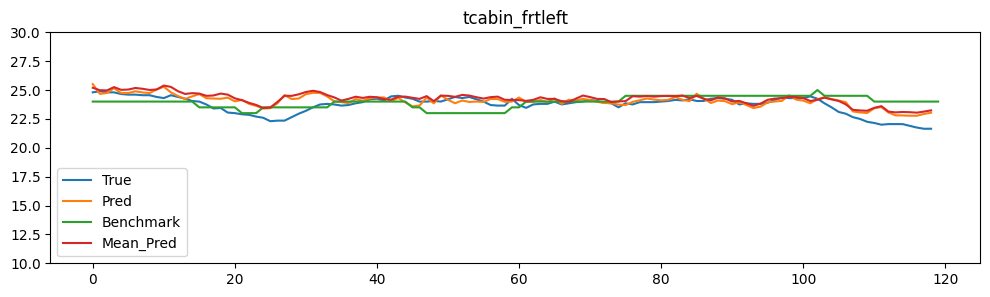

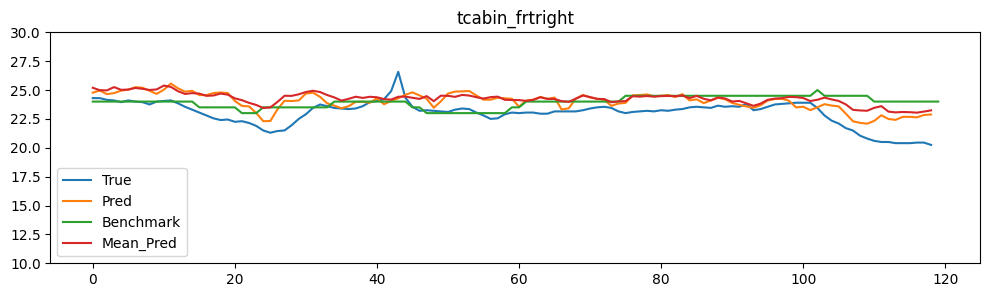

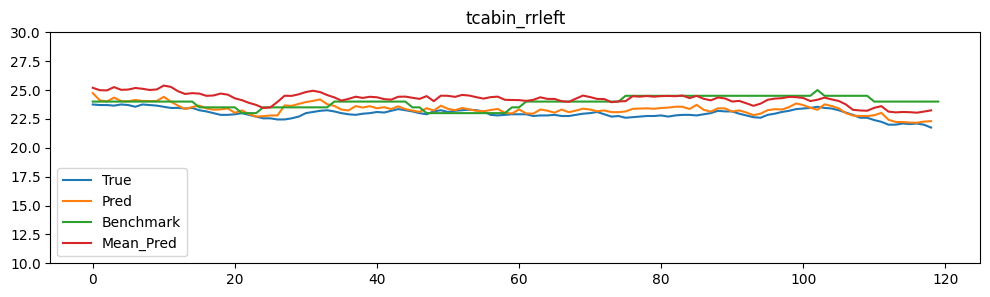

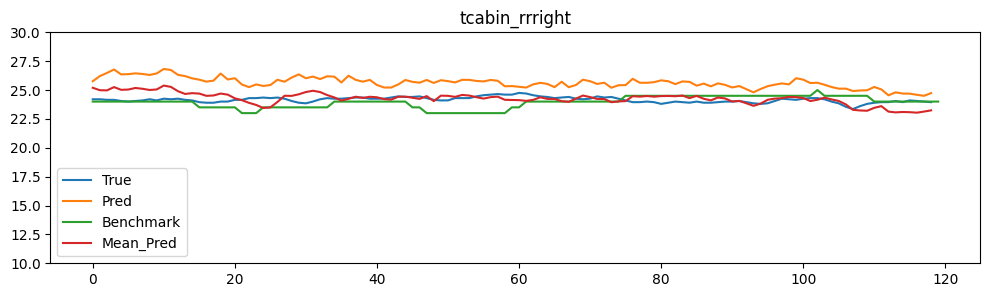

119it [00:07, 16.70it/s]


simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_02_ForceTT33_Winter-20211227100717_IdleAuto23SteadyCaliration@-Amb12_NoSolar2Solar.xlsx
Test MAE:
 [0.76786936 0.70263897 2.70920228 0.37188294]


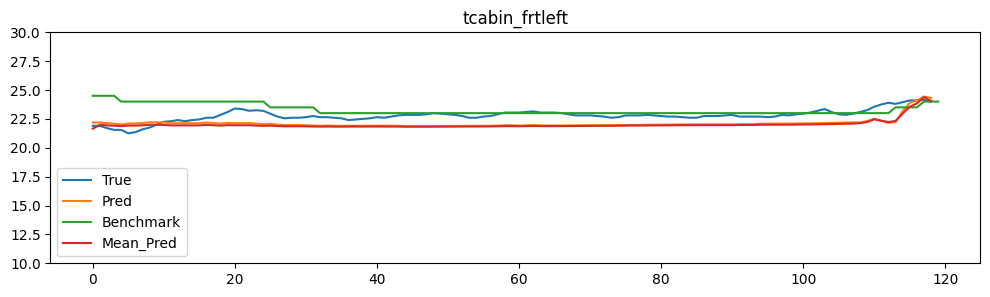

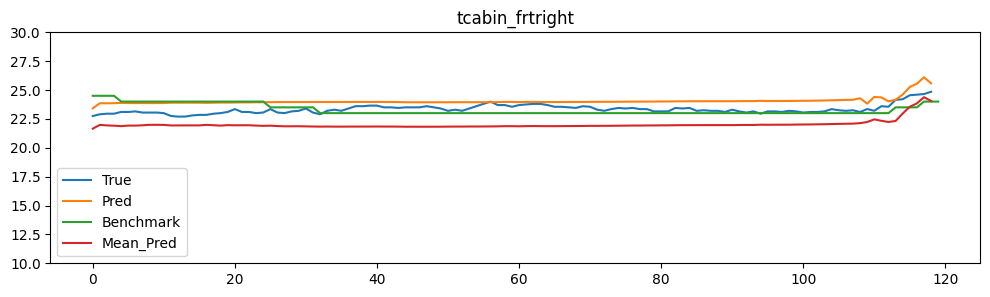

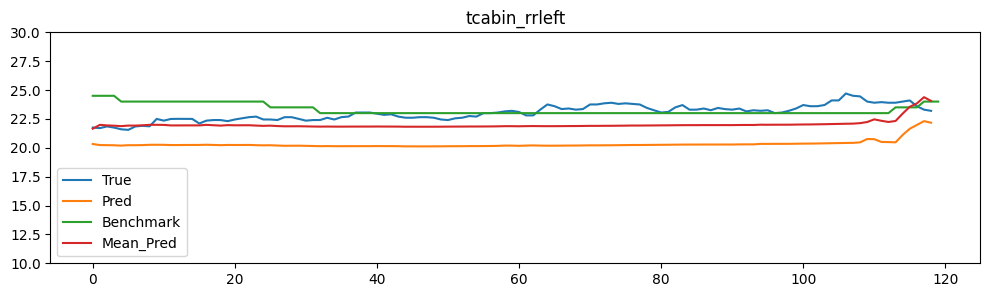

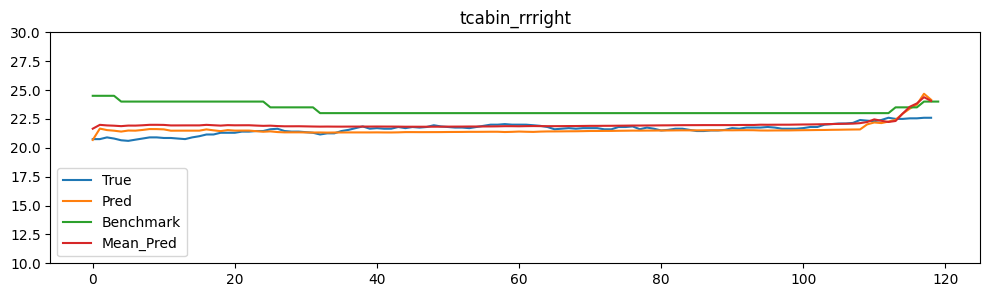

119it [00:07, 15.33it/s]


simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_03_ForceTT33_Winter-20211227155039_DrivingAuto23@Amb-15_Low&HighSpeed.xlsx
Test MAE:
 [1.62165643 1.58047819 2.18724978 2.77765614]


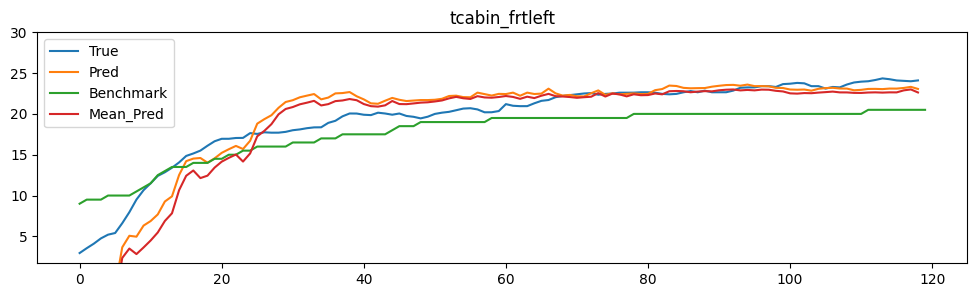

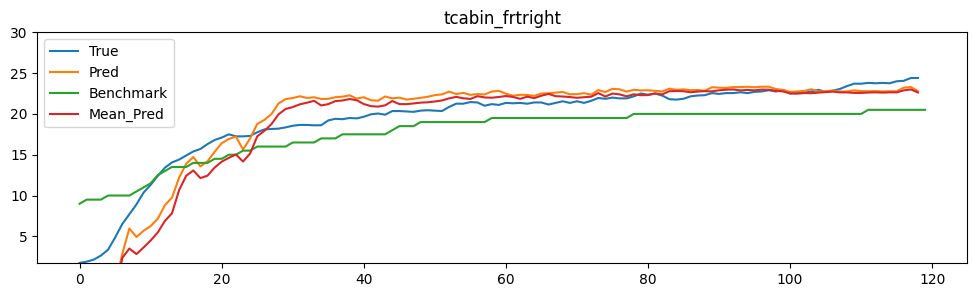

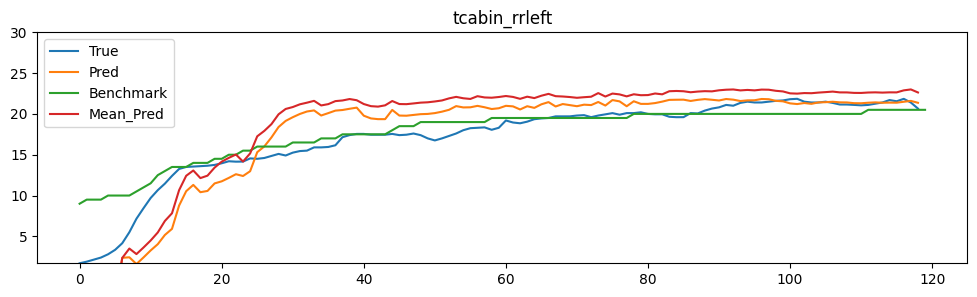

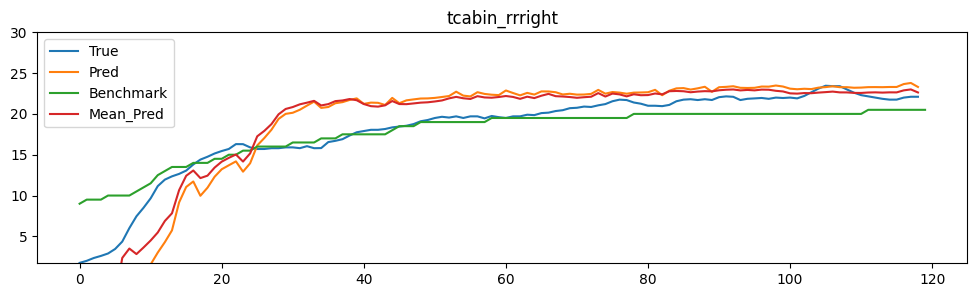

119it [00:08, 14.36it/s]


simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_05_-13Amb_Auto23Rearoff-20220114172010.xlsx
Test MAE:
 [1.78254657 3.36889441 2.48964506 2.3385992 ]


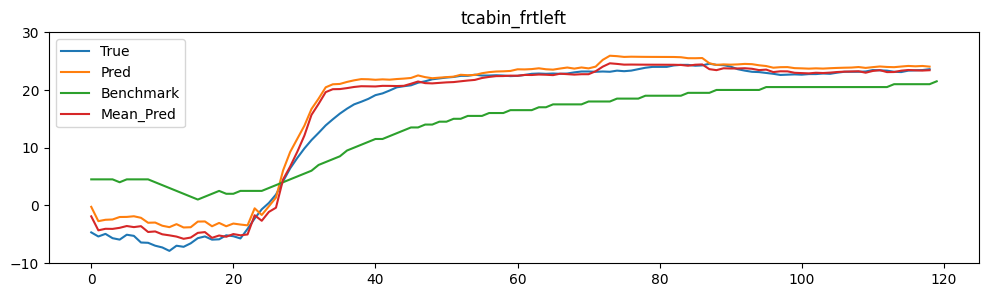

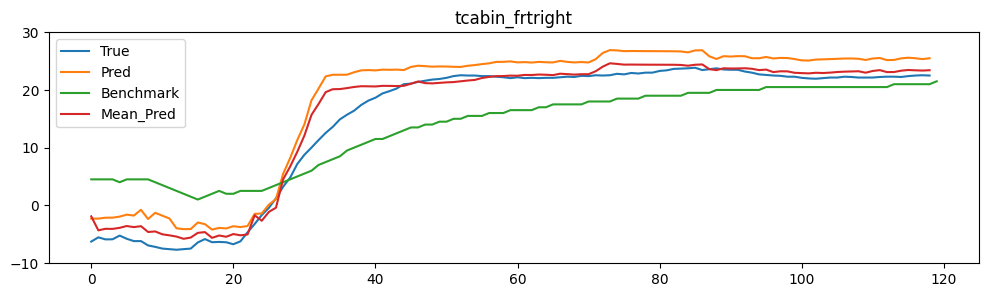

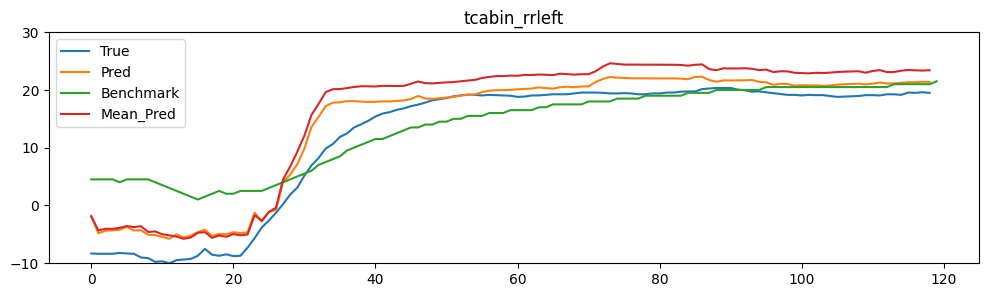

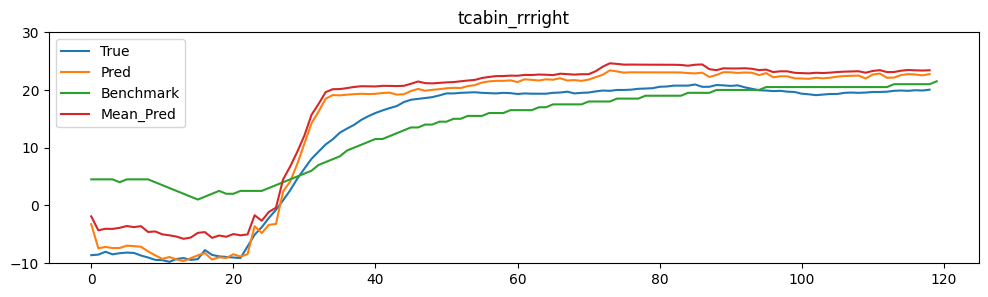

119it [00:07, 15.08it/s]


simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_3.山路 auto23.xlsx
Test MAE:
 [1.14713538 1.79086335 1.63293209 2.10380334]


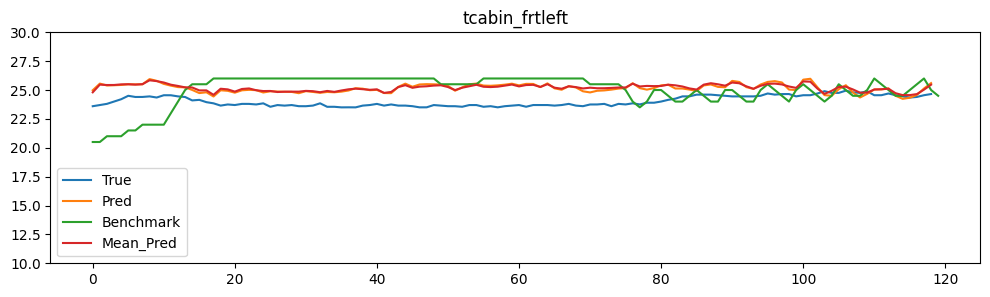

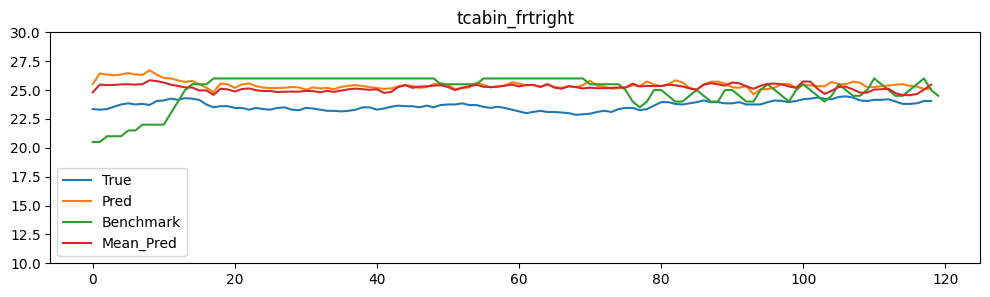

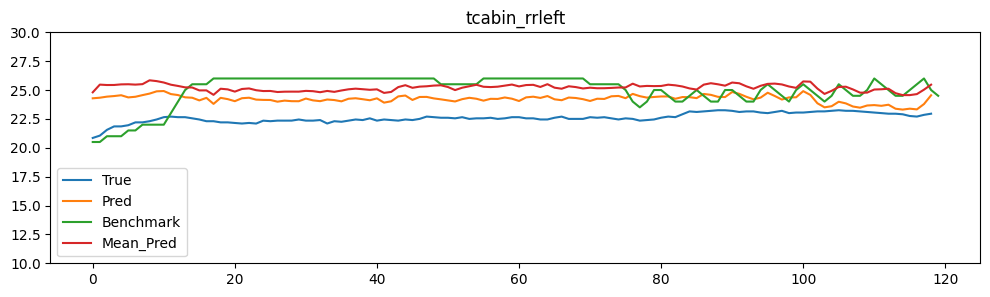

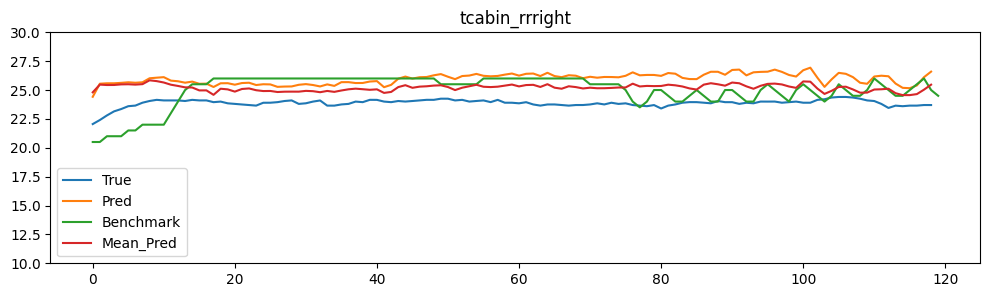

119it [00:07, 15.36it/s]


simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Winter Test/Test_2_HotStart_Auto_23_FrOnRrOn_HPOnly-AMB=-8_VB-43-050-05RC-V2-LH_20-11-2021 15_04_50.dat
Test MAE:
 [1.36178581 2.82815313 1.95355997 3.54887385]


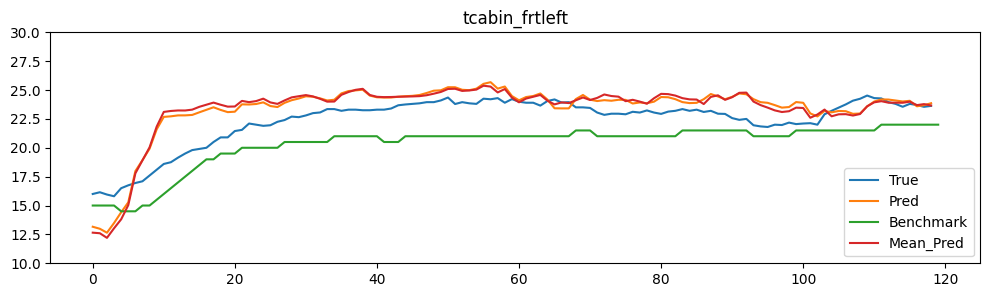

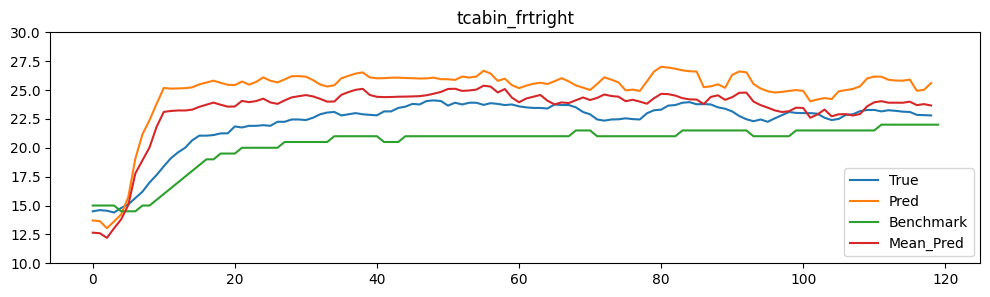

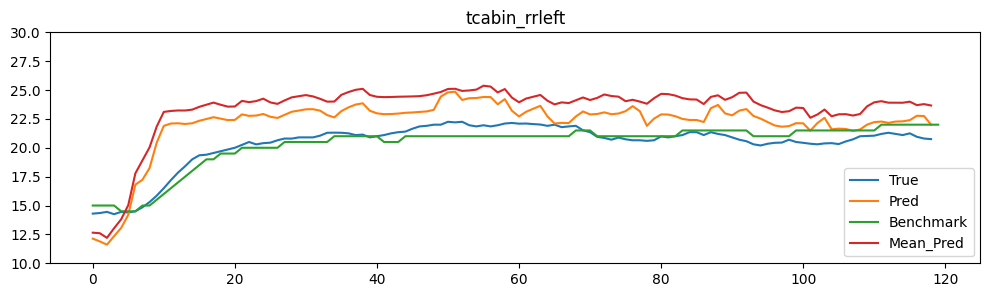

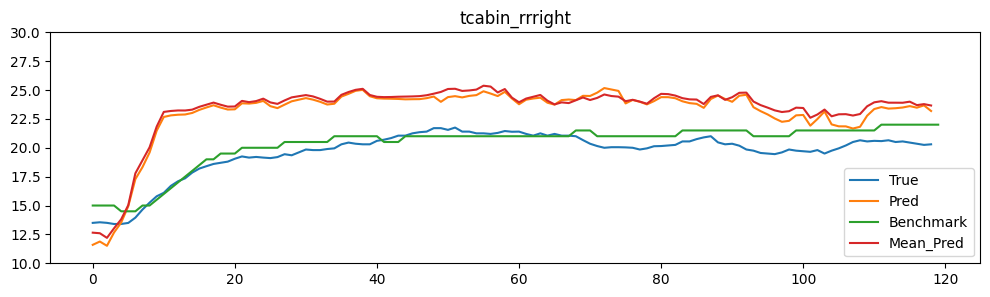

119it [00:07, 15.89it/s]


simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/V7-高速+城市-Auto-23-25-07-2021 19_05_10.dat
Test MAE:
 [0.83827151 1.32736362 2.80814306 1.95883934]


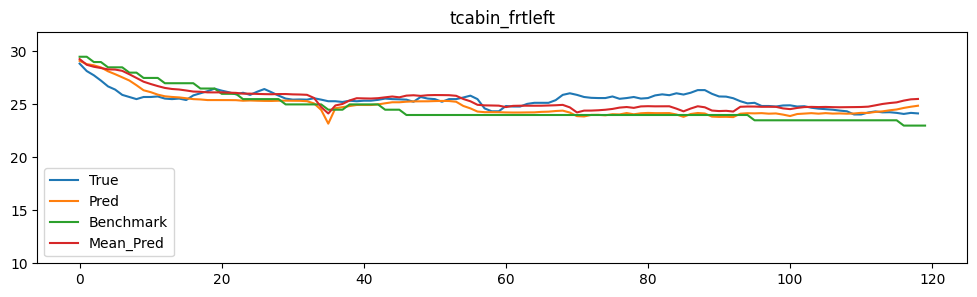

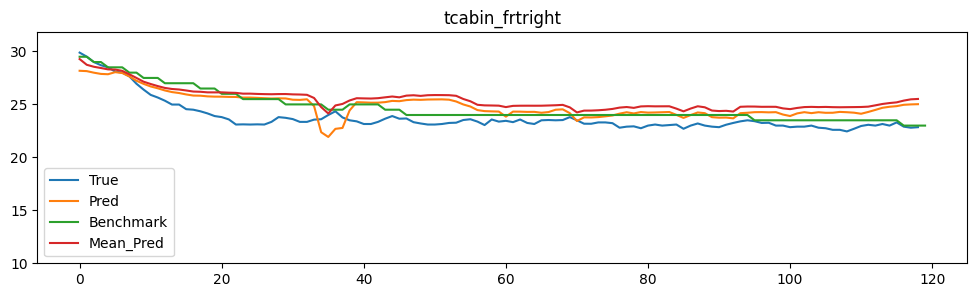

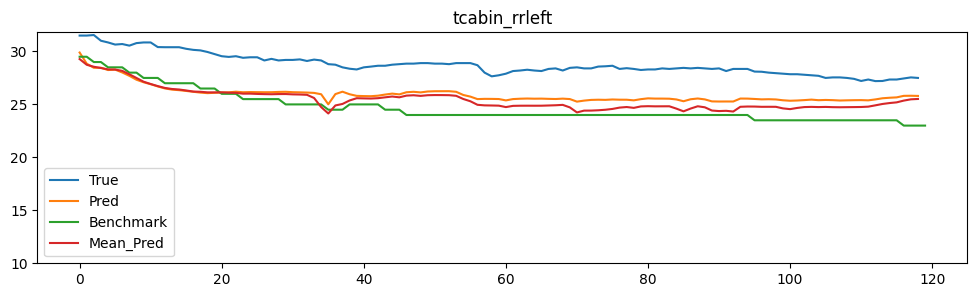

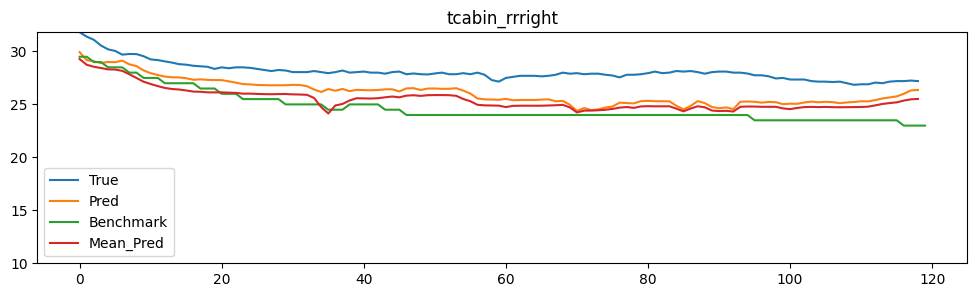

Overall MAE: [1.1442081  1.81353634 2.02242714 2.08345874]


In [30]:
with tf.device('/GPU:2'):  
    model=models.load_model('1.1model_summer&winter_tinit')
    Test(model,validate_data)

119it [00:08, 13.90it/s]


simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_01_VB23_AutumnTest_SyncAuto23@Amb6-20211118102426.xlsx
Test MAE:
 [0.58649809 0.62742066 0.79033797 0.88401292]


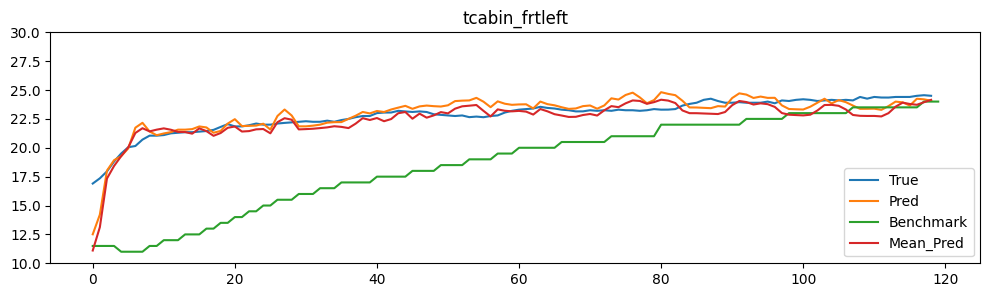

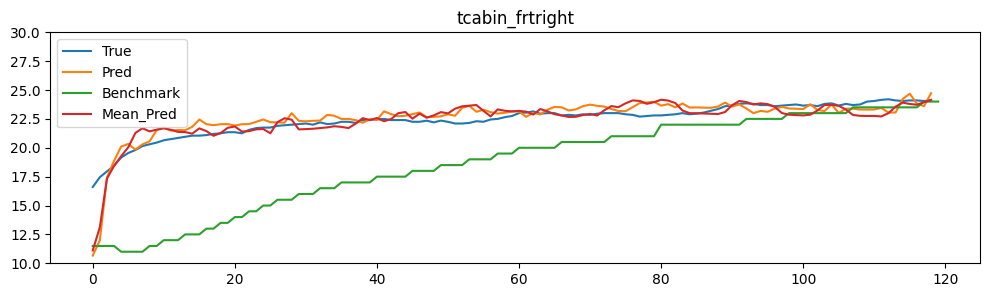

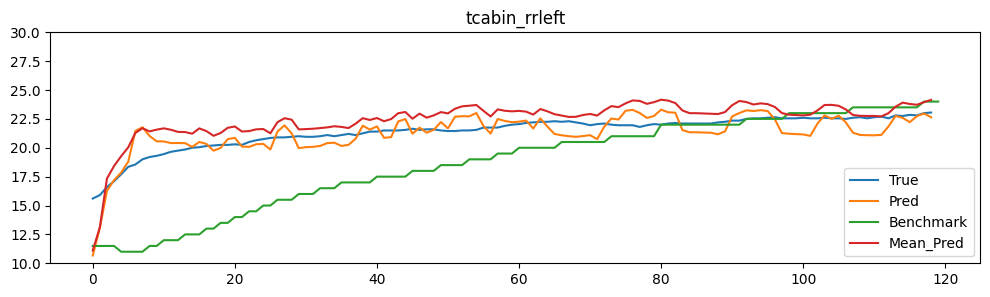

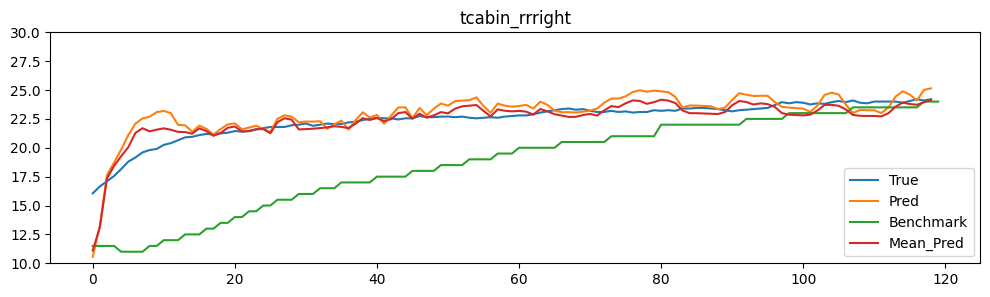

119it [00:07, 15.12it/s]


simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_03_VB23_AutumnTest_CityAuto23-20211117153252.xlsx
Test MAE:
 [0.58403547 1.10615061 1.02051523 1.33865289]


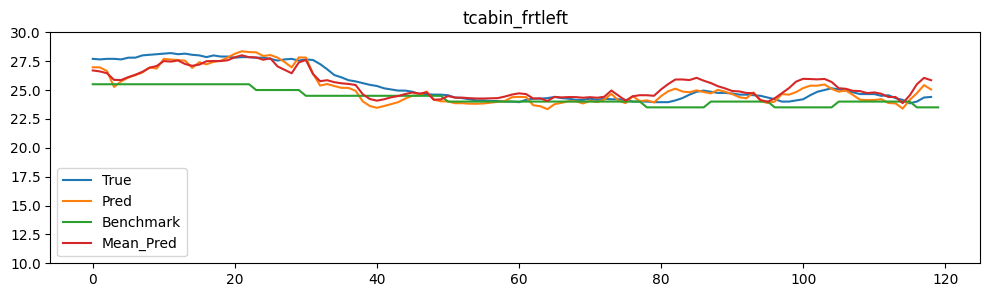

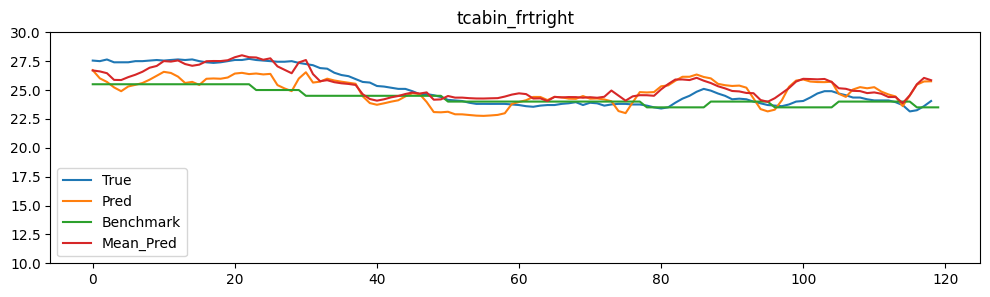

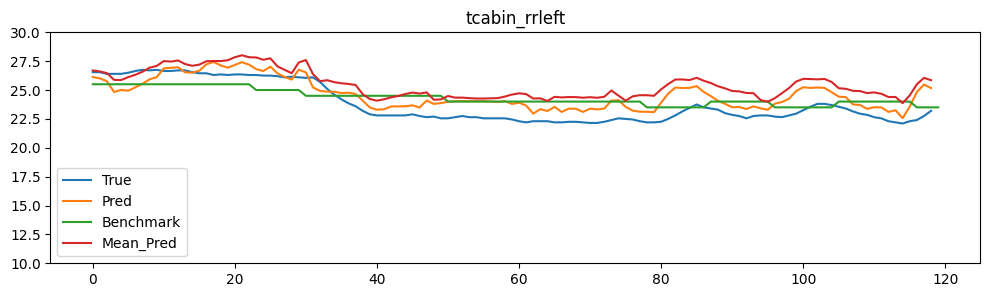

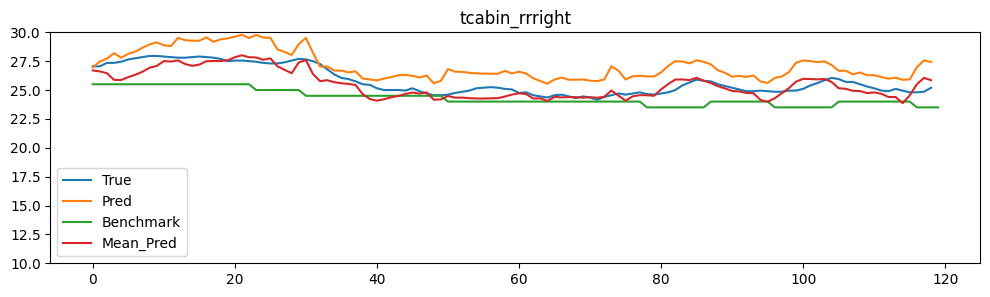

86it [00:05, 16.38it/s]


simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_2-23/Autumn Test/Test_Model_2.auto23_L1toL2_-1.5.xlsx
Test MAE:
 [0.98463686 1.44792915 1.06841207 0.5812913 ]


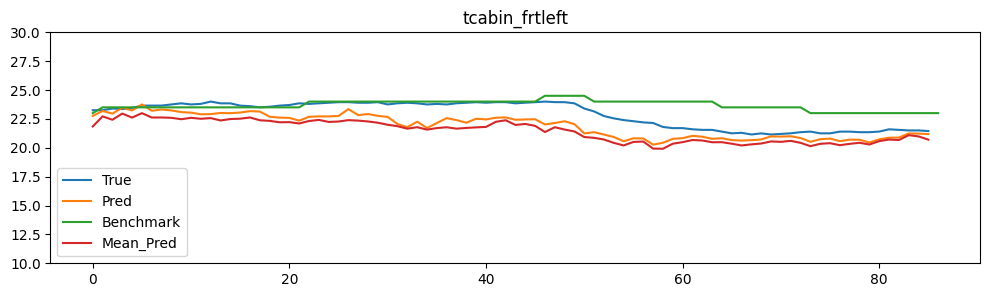

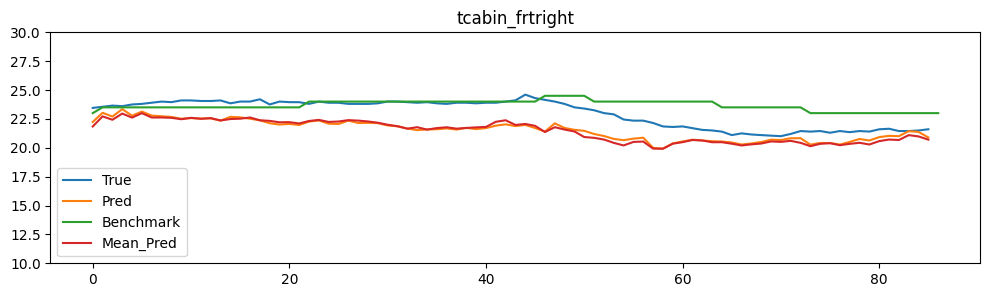

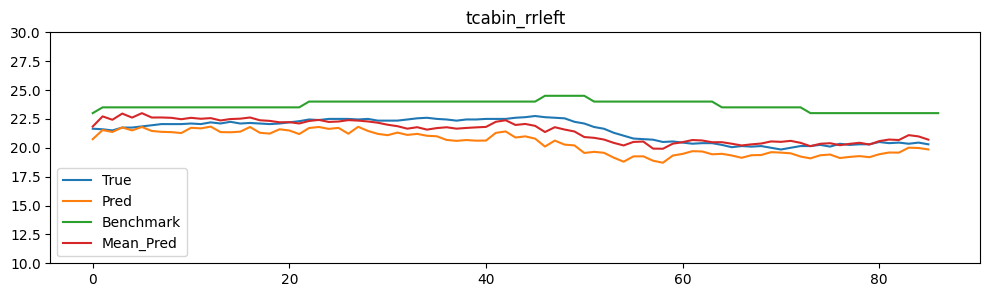

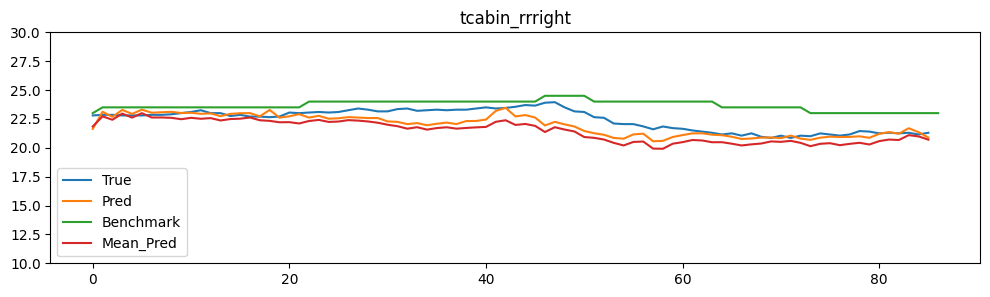

119it [00:08, 14.79it/s]


simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_01_ForceTT33_Winter_Auto23Driving-20211219150552.xlsx
Test MAE:
 [2.47106801 2.90373512 3.38172946 3.91434423]


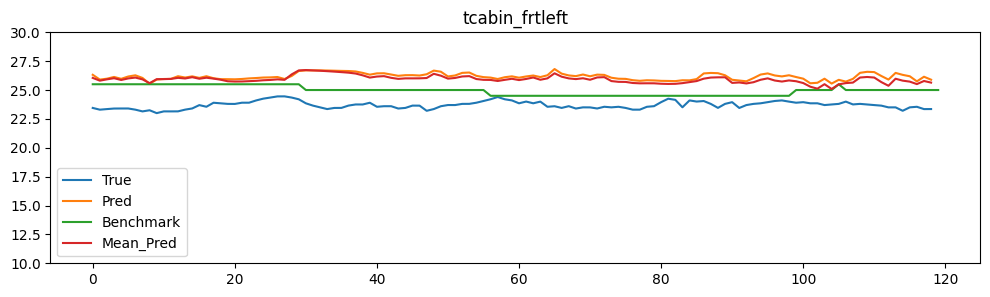

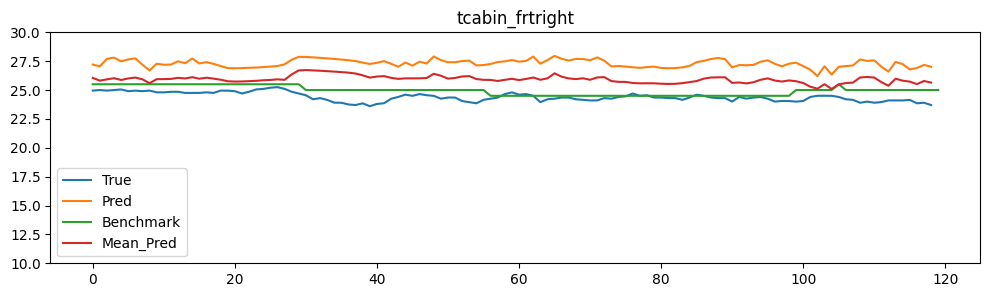

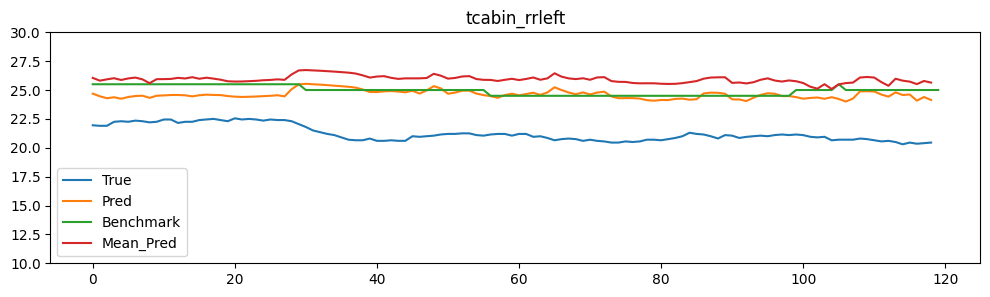

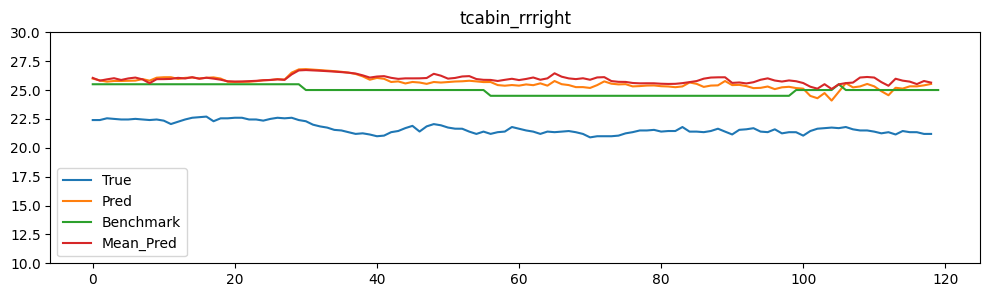

80it [00:05, 15.69it/s]


simulation_raw_data/thermo/in_car_model/ET7/Auto 23/TT_1-33/Winter_Test/Test_Model_03_ForceTT33_Winter_Tset23ManulBlowerLevel1@Amb-17_-20211217161353.xlsx
Test MAE:
 [1.3644781  2.58638614 2.4431344  1.57640686]


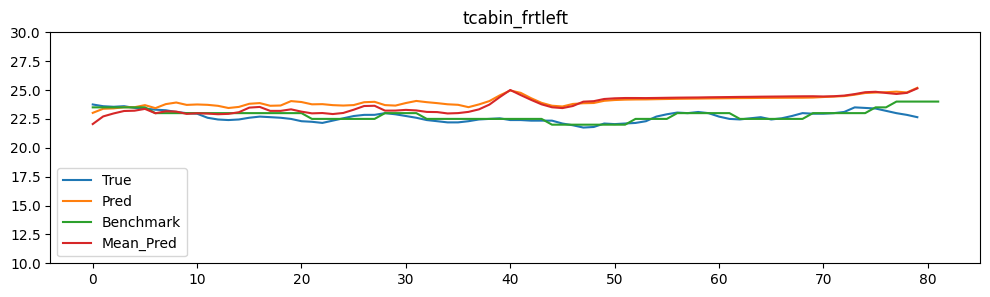

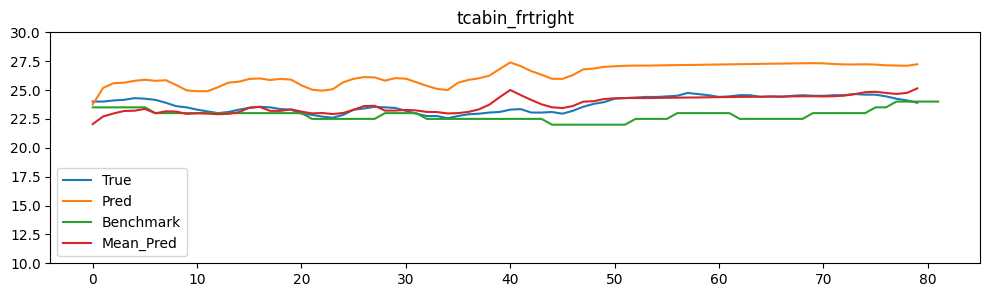

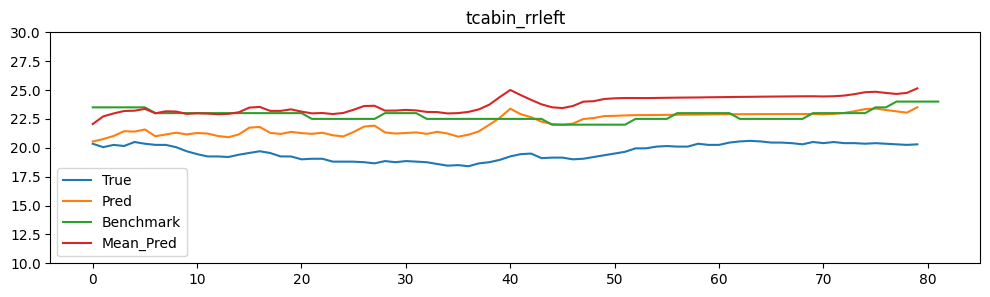

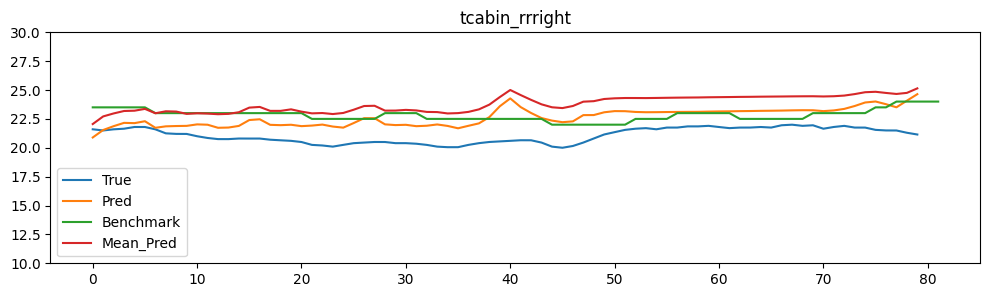

107it [00:07, 13.75it/s]


simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Winter Test/Test_8_frnton-rearon-_Auto_23_PTC-0nly-AMB=-12-AMBtest_VB-43-050-05RC-V2-LH_23-11-2021 14_16_07.dat
Test MAE:
 [0.43671369 0.98057536 1.68809505 2.80683066]


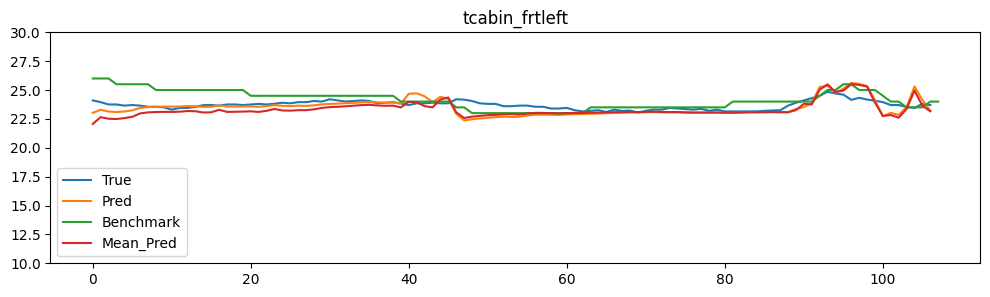

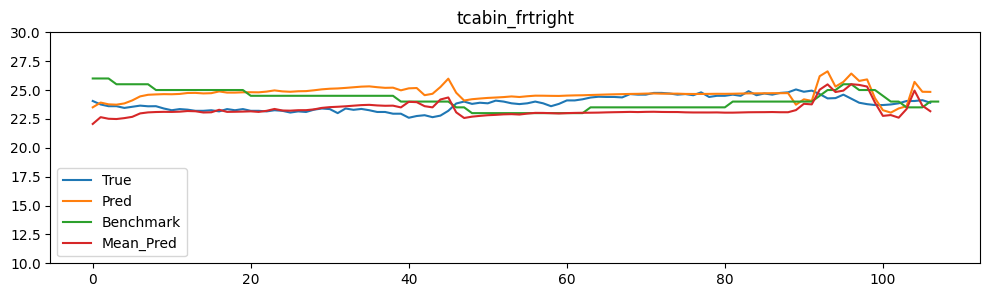

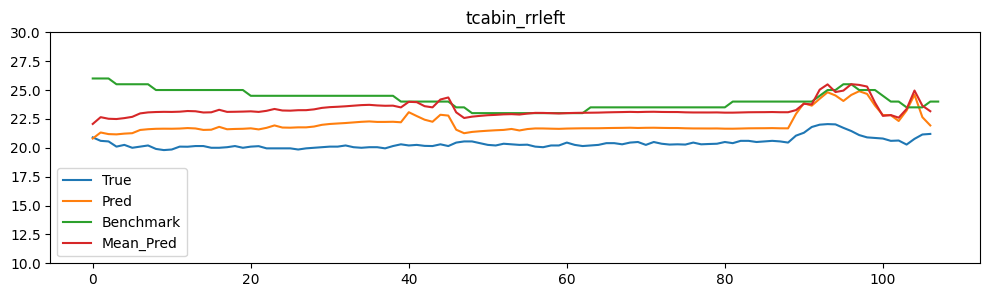

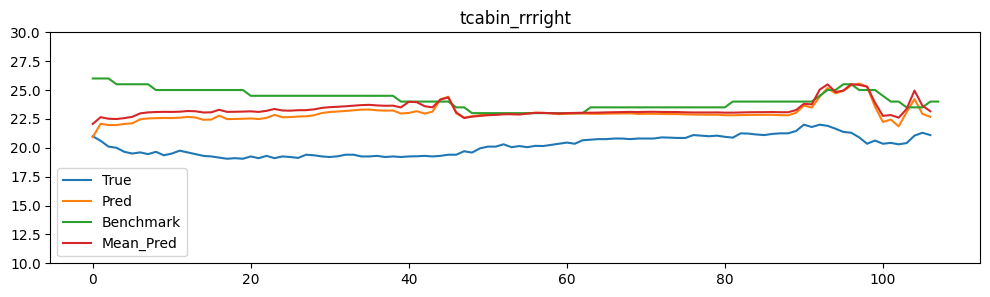

119it [00:07, 16.19it/s]


simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/V7-AUTO-23-高速+城市-26-07-2021 18_54_12.dat
Test MAE:
 [2.25278917 2.43237151 0.7975752  1.08064801]


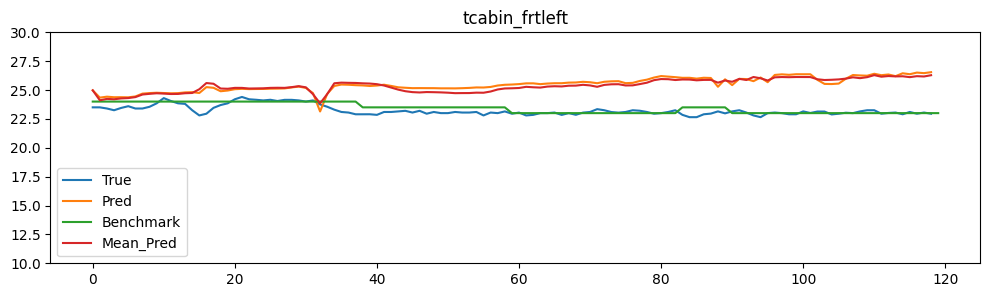

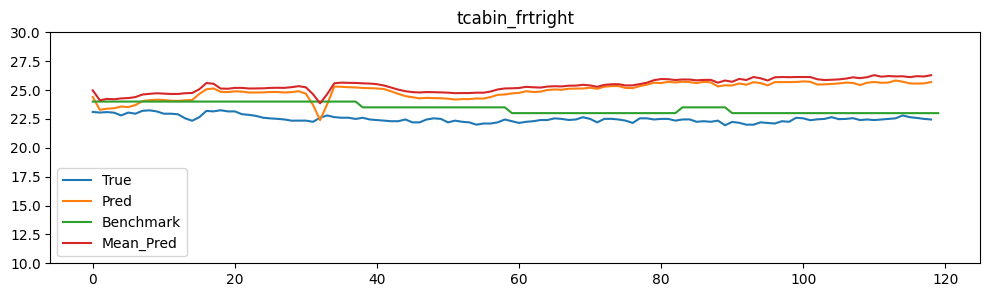

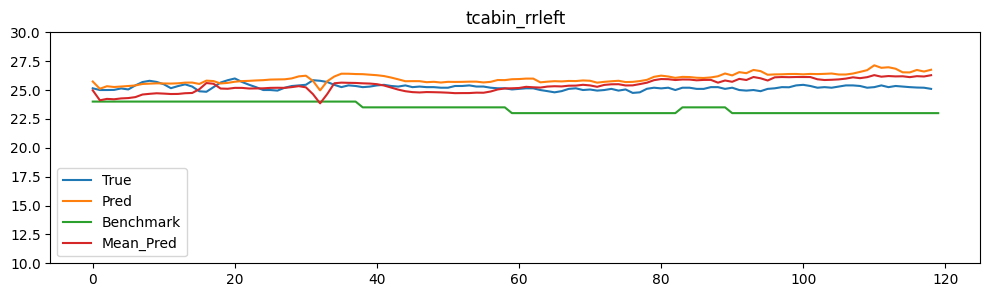

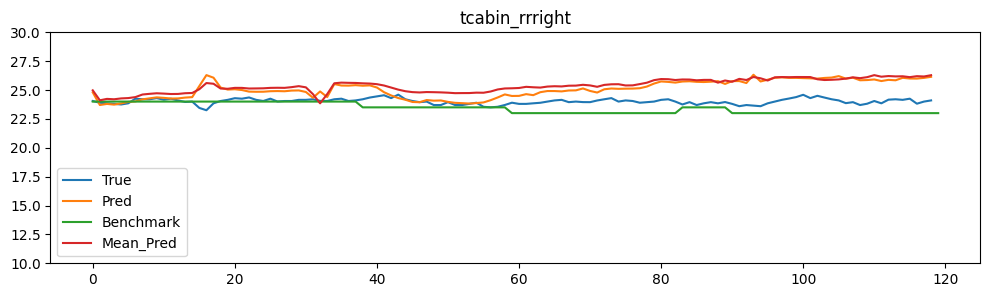

87it [00:06, 14.38it/s]

simulation_raw_data/thermo/in_car_model/ET7/Auto 23/VB_1-43/Summer Test/Auto-23-城市工矿_27-07-2021 21_12_32.dat
Test MAE:
 [0.71663905 1.40431309 0.70907779 0.84537224]


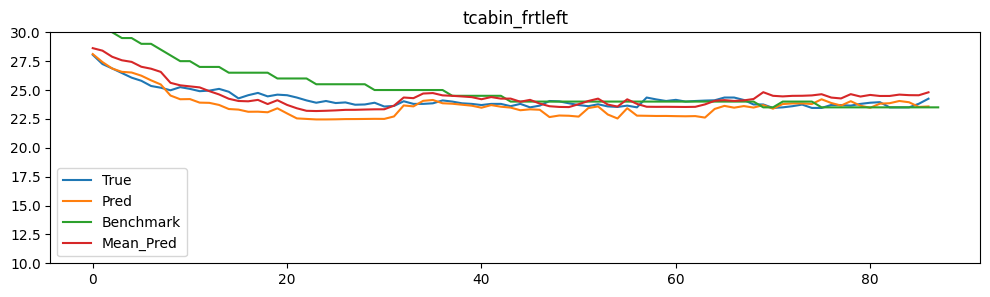

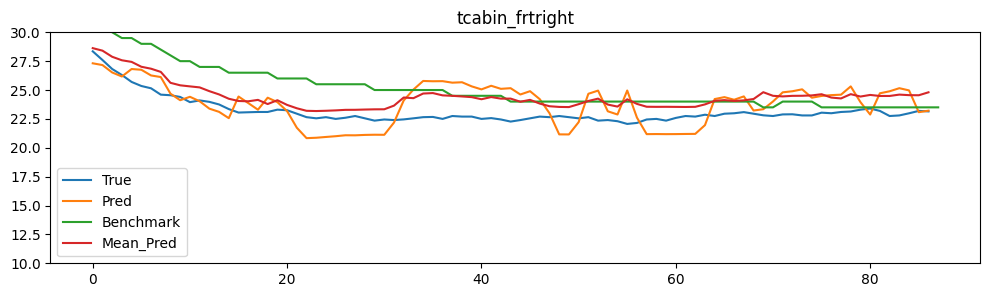

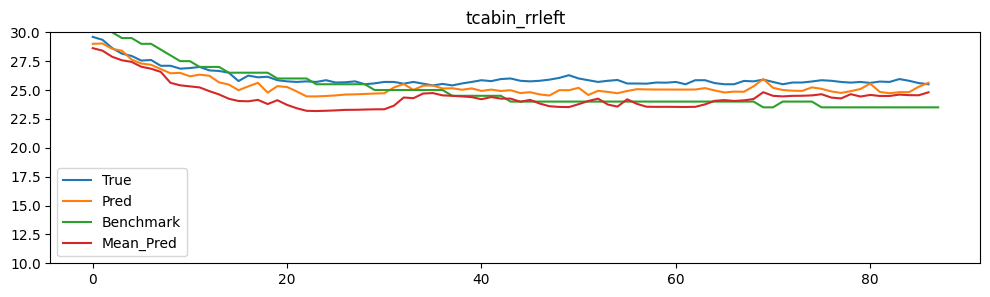

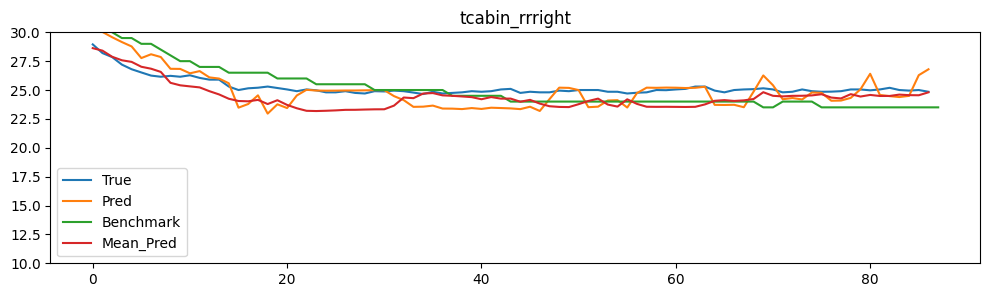

Overall MAE: [1.1746073  1.68611021 1.48735965 1.62844489]


In [31]:
with tf.device('/GPU:2'):  
    model=models.load_model('1.1model_summer&winter_tinit')
    Test(model,test_data)

In [22]:
model_pretrained=models.load_model('model_summer&winter_Attention')
model=build_model(1)
model.set_weights(model_pretrained.get_weights())
model.compile(loss='mse',optimizer=optimizers.RMSprop(learning_rate=0.001),metrics='mae') 
model.save('5.model_summer&winter_PretrainStateful')

INFO:tensorflow:Assets written to: model_summer&winter_PretrainStateful/assets


INFO:tensorflow:Assets written to: model_summer&winter_PretrainStateful/assets
